**Часть 1: получение данных, визуализация и статистики**

### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import math
import random

import yfinance as yf

import datetime
from datetime import datetime

from copy import copy, deepcopy

import sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

## Сбор данных

https://bcs-express.ru/kotirovki-i-grafiki/imoex

In [4]:
# Выбор периода
start_date = '2010-01-01'
end_date = '2023-12-31'

# Выбор тикеров
tickers_list = ['IMOEX.ME', 'EURUSD=X', 'GBPUSD=X',
                'SBER.ME', 'VTBR.ME',
                'MTSS.ME',
                'LKOH.ME', 'ROSN.ME',
                'MSFT']
print(len(tickers_list))

rename_columns = {'IMOEX.ME':'IMOEX',
        'SBER.ME':'Сбербанк', 'VTBR.ME':'ВТБ',
        'YNDX.ME':'Яндекс', 'AFLT.ME':'Аэрофлот', 'MTSS.ME':'МТС',
        'LKOH.ME':'Лукойл', 'GAZP.ME':'Газпром', 'ROSN.ME':'Роснефть',
        'MSFT':'Microsoft'}

# adjusted close prices
price_column = 'Adj Close'

9


In [5]:
df_price = yf.download(tickers = tickers_list,
                        start = start_date,
                        end = end_date,
                        interval = '1d')[price_column]

df_price.index = pd.to_datetime(df_price.index, format='%Y-%m-%d')
df_price.sort_index(inplace=True)

df_price.rename(columns=rename_columns, inplace=True)

[*********************100%%**********************]  9 of 9 completed


In [6]:
df_price.isnull().sum()

Ticker
EURUSD=X        5
GBPUSD=X        5
IMOEX         984
Лукойл        608
Microsoft     129
МТС          1036
Роснефть      608
Сбербанк     1036
ВТБ           608
dtype: int64

In [7]:
df_price.columns

Index(['EURUSD=X', 'GBPUSD=X', 'IMOEX', 'Лукойл', 'Microsoft', 'МТС',
       'Роснефть', 'Сбербанк', 'ВТБ'],
      dtype='object', name='Ticker')

## Анализ

### Класс

In [8]:
class FinancialInstrument:
    def __init__(self, df, name):
        """
            Входные данные:
            df - DataFrame с ценами
            name - наименование фин. инструмента (акция, курс валют и т.д.)
        """
        self.name = name
        self.data_price = df[[name]] # ряд цен
        self.data = self.calculate_returns() # ряд дохоностей
        self.data_price['date'] = df.index
        self.data['date'] = self.data.index
        self.T = self.data.shape[0]

    def calculate_returns(self):
        """ Вычисление ряда доходностей. """
        return self.data_price.pct_change().dropna()

    def price_dynamics(self, fig_size=(14, 5)):
        """ Ф-я отображает ряд цен. """
        fig = go.Figure()
        fig.update_layout(
            autosize=False,
            width=fig_size[0]*100,
            height=fig_size[1]*100,
            title=f'{self.name}: prices')
        g1 = go.Scatter(x=self.data_price['date'], y=self.data_price[self.name])
        fig.add_trace(g1)
        fig.show()

    def returns_dynamics(self, fig_size=(14, 6)):
        """ Ф-я отображает ряд доходностей. """
        fig = go.Figure()
        fig.update_layout(
            autosize=False,
            width=fig_size[0]*100,
            height=fig_size[1]*100,
            title=f'{self.name}: daily returns')
        g1 = go.Scatter(x=self.data['date'], y=self.data[self.name])
        fig.add_trace(g1)
        fig.show()

    def histogram(self, bins=100, fig_size=(14, 5)):
        """
            Ф-я отображает гистограмму распределения значений доходностей.
            По умолчанию bins = 100.
        """

        coef_skew, txt1 = self.skewness(print_info=0, return_info=1)
        coef_kurtosis, txt2 = self.kurtosis(print_info=0, return_info=1)

        fig, axs = plt.subplots(1, 1, figsize = fig_size)
        g1 = sns.histplot(data = self.data, x = self.name, bins = bins,
                            stat = 'density', kde = True,
                            ax = axs, color = 'steelblue')
        g1.set(title=f'{self.name}: histogram of daily returns \n Skewness = {coef_skew} ({txt1}) \n Kurtosis = {coef_kurtosis} ({txt2})')
        g1.set(xlabel = None, ylabel = None)
        axs.axvline(x=0, color='indianred', linewidth=0.75)
        plt.show()

    def stationarity_adf(self, series=None, lev=0.05):
        series = self.data[self.name] if series is None else series
        adf_test = sm.tsa.adfuller(series)
        if (adf_test[1] < lev):
            res = 'the series is stationary.'
        else:
            res = 'the series is not stationary.'
        print(f'ADF test: {res}')

    def stationarity_kpss(self, series=None, lev=0.05):
        series = self.data[self.name] if series is None else series
        kpss_test = sm.tsa.kpss(series)
        if (kpss_test[1] < lev) :
            res = 'the series is not stationary.'
        else:
            res = 'the series is stationary.'
        print(f'KPSS test: {res}')

    def stationarity_test(self, returns=None, lev=0.05):
        self.stationarity_adf(series=returns, lev=lev)
        self.stationarity_kpss(series=returns, lev=lev)

    def skewness(self, print_info=0, return_info=1):
        """
            Ф-я вычисления коэффициента асимметрии.
            Если print_info=1, выводится значение коэффициента и комментарий.
            Если return_info=1, возвращается значение коэффициента.
        """
        coef_skew = stats.skew(self.data[self.name])
        if coef_skew == 0:
            full_txt = "Symmetrical."
            stort_txt = "symmetrical"
        elif coef_skew < 0:
            full_txt = "The left tail of the distribution is longer or stretched out."
            short_txt = "left skewed"
        else:
            full_txt = "The right tail of the distribution is longer or stretched out."
            short_txt = "right skewed"

        if print_info:
            print('Skewness: ', np.round(coef_skew, 3))
            print(full_txt)
        if return_info:
            return np.round(coef_skew, 2), short_txt

    def kurtosis(self, print_info=0, return_info=1):
        """
            Ф-я вычисления коэффициента эксцесса.
            Если print_info=1, выводится значение коэффициента и комментарий.
            Если return_info=1, возвращается значение коэффициента.
        """
        coef_kurt = stats.kurtosis(self.data[self.name])
        if coef_kurt == 0:
            full_txt = "Mesokurtic. This distribution has a kurtosis similar to that of the normal distribution."
            short_txt = "mesokurtic"
        elif coef_kurt > 0:
            full_txt = "Leptokurtic. This distribution appears as a curve one with long tails."
            short_txt = "leptokurtic"
        else:
            full_txt = "Playkurtic. These types of distributions have short tails."
            short_txt = "playkurtic"

        if print_info:
            print('Kurtosis: ', np.round(coef_kurt, 3))
            print(full_txt)
        if return_info:
            return np.round(coef_kurt, 2), short_txt

    def get_moving_dynamic(self, window_size=250, fig_size=(16, 10)):
        """
            Ф-я отображает среднее значение, стандартное отклонение, коэффициент асимметрии и коэффициент эксцесса в динамике.
            window_size - размер окна, на котором вычисляются значения.
        """
        mean_lst, std_lst, skew_lst, kurt_lst = [], [], [], []
        for i in range(window_size, self.T):
            ret = self.data[self.name][i-window_size : i]
            mean_lst.append(np.mean(ret))
            std_lst.append(np.std(ret))
            skew_lst.append(stats.skew(ret))
            kurt_lst.append(stats.kurtosis(ret))

        fig, axs = plt.subplots(4, 1, figsize = fig_size)
        axs[0].plot(self.data.index[window_size:], mean_lst, color='steelblue', linewidth=0.8)
        axs[0].set_ylabel('Mean')
        axs[1].plot(self.data.index[window_size:], std_lst, color='steelblue', linewidth=0.8)
        axs[1].set_ylabel('Standard deviation')
        axs[2].plot(self.data.index[window_size:], skew_lst, color='steelblue', linewidth=0.8)
        axs[2].axhline(y=0, color='indianred', linewidth=0.6)
        axs[2].set_ylabel('Skewness')
        axs[3].plot(self.data.index[window_size:], kurt_lst, color='steelblue', linewidth=0.8)
        axs[3].axhline(y=3, color='indianred', linewidth=0.6)
        axs[3].set_ylabel('Kurtosis')
        plt.show()

    def qq_plot(self, dist=None, fig_size=(5, 5)):
        """
            Ф-я отображает QQ-plot.
            Доступные распределения: norm, skew norm, t, noncentral t, GPD, GEV
        """
        dist_lst = {'norm': stats.norm,
                    'skew norm': stats.skewnorm,
                    't': stats.t,
                    'noncentral t': stats.nct,
                    'GPD': stats.genpareto,
                    'GEV': stats.genextreme
                }
        if dist is None:
            dist = 'norm'
        elif dist not in dist_lst.keys():
            avl = [i for i in dist_lst.keys()]
            while dist not in dist_lst.keys():
                print('Указанного распределения нет в списке доступных.')
                print('Доступные: ', ', '.join(avl))
                dist = input('Введите распределение: ')

        fig, axs = plt.subplots(1, 1, figsize = fig_size)
        # sm.qqplot(self.data[self.name], fit=True, line = 'q')
        params = dist_lst[dist].fit(self.data[self.name])
        stats.probplot(self.data[self.name], fit=True, dist=dist_lst[dist], sparams=params, plot=plt)
        axs.set_title(f'Probability Plot  ({dist})')
        plt.show()

### IMOEX

In [9]:
imoex = FinancialInstrument(df = df_price, name = 'IMOEX')

In [10]:
imoex.price_dynamics()

In [11]:
imoex.returns_dynamics()

In [12]:
warnings.filterwarnings("ignore")

imoex.stationarity_test()

ADF test: the series is stationary.
KPSS test: the series is stationary.


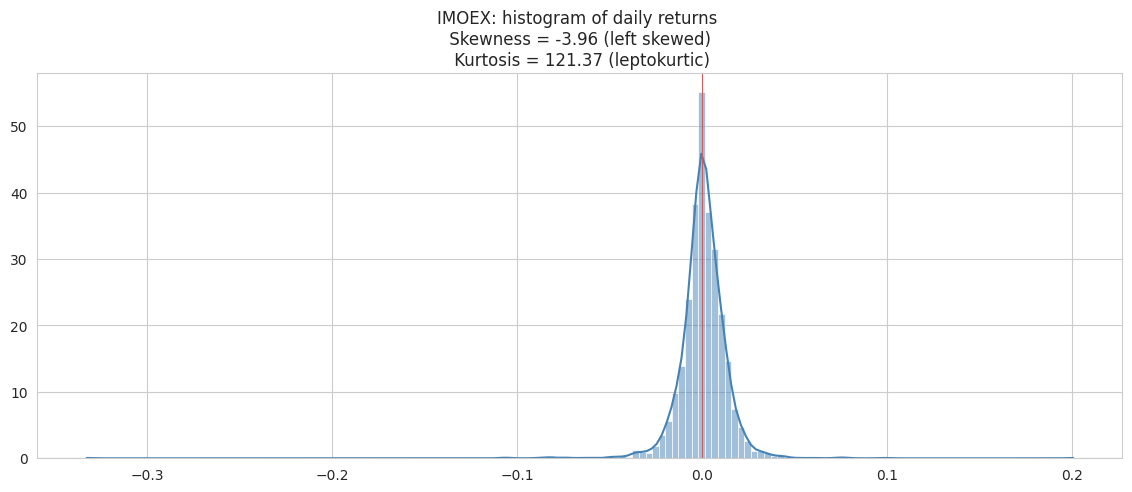

In [13]:
imoex.histogram(bins=150)

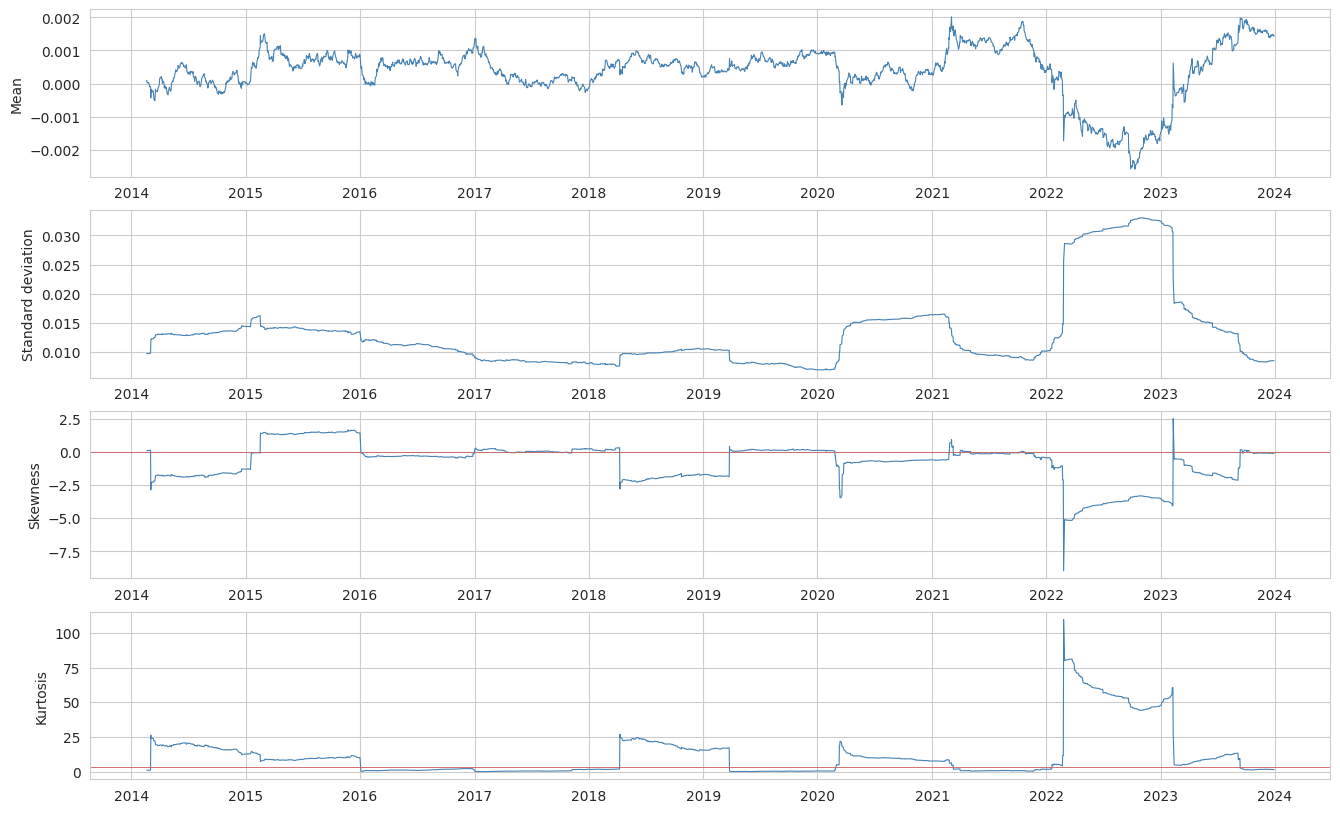

In [14]:
imoex.get_moving_dynamic(window_size=250)

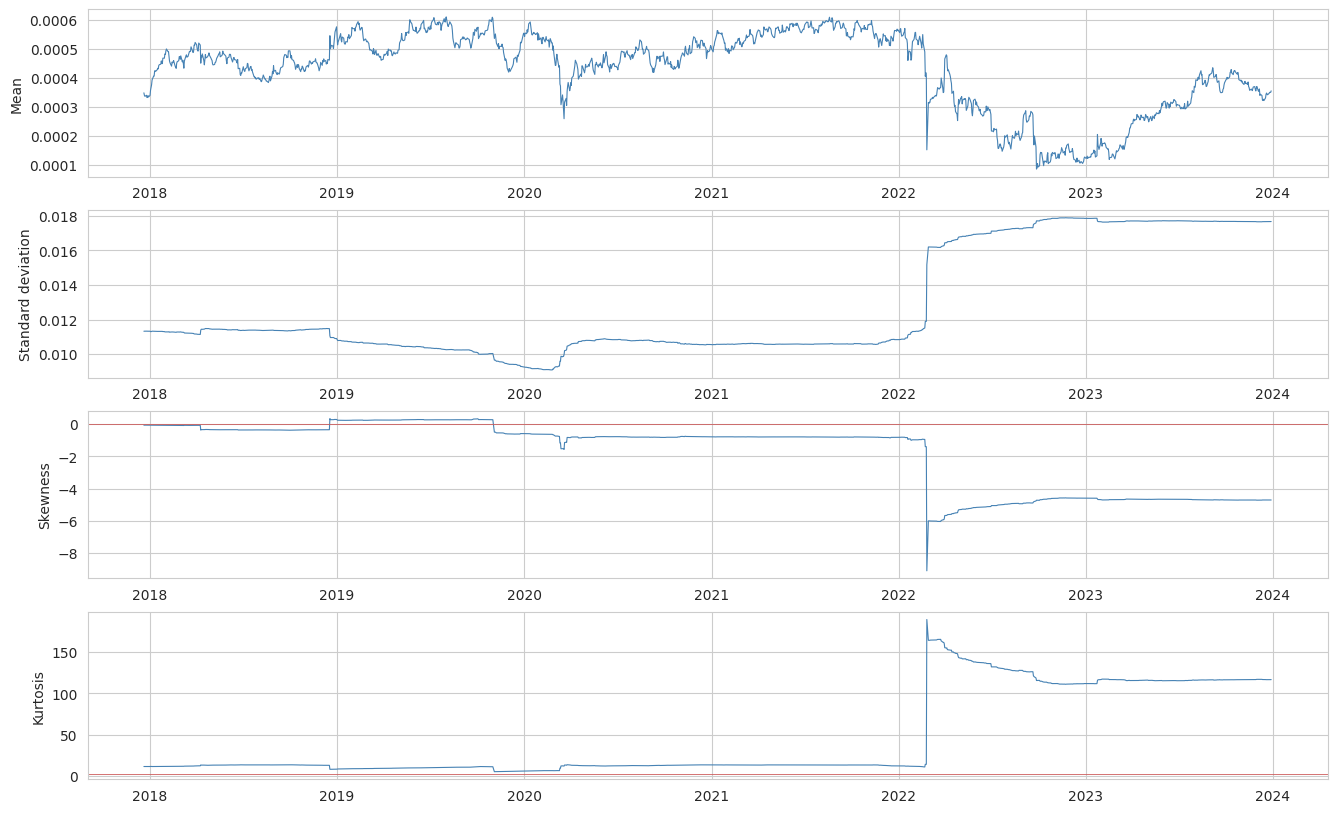

In [15]:
imoex.get_moving_dynamic(window_size=1250)

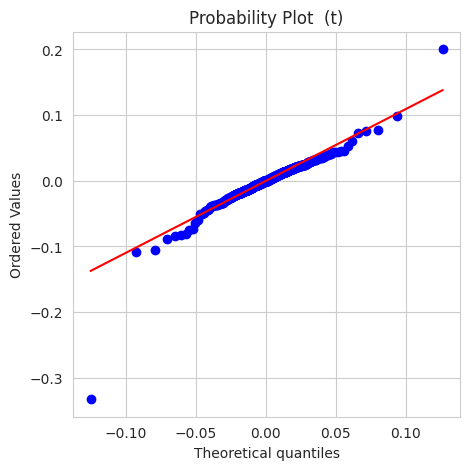

In [16]:
imoex.qq_plot(dist='t')

Указанного распределения нет в списке доступных.
Доступные:  norm, skew norm, t, noncentral t, GPD, GEV
Введите распределение: GPD


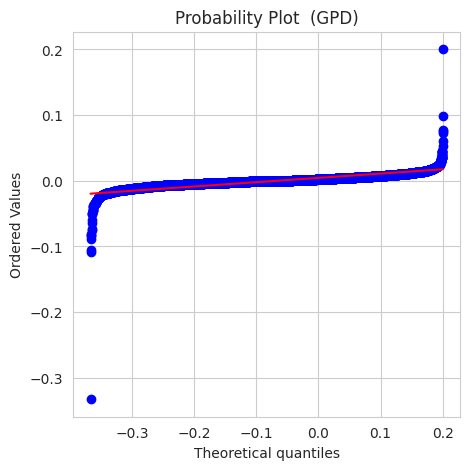

In [17]:
imoex.qq_plot(dist='beta')

### Сбербанк

In [18]:
stock = FinancialInstrument(df = df_price, name = 'Сбербанк')

In [20]:
stock.price_dynamics()

In [21]:
stock.returns_dynamics()

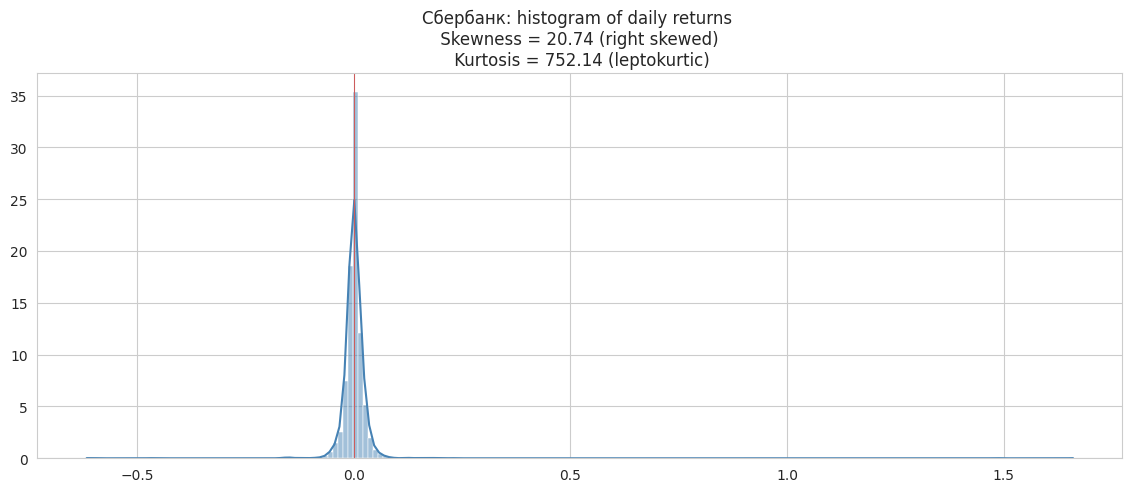

In [24]:
stock.histogram(bins=200)

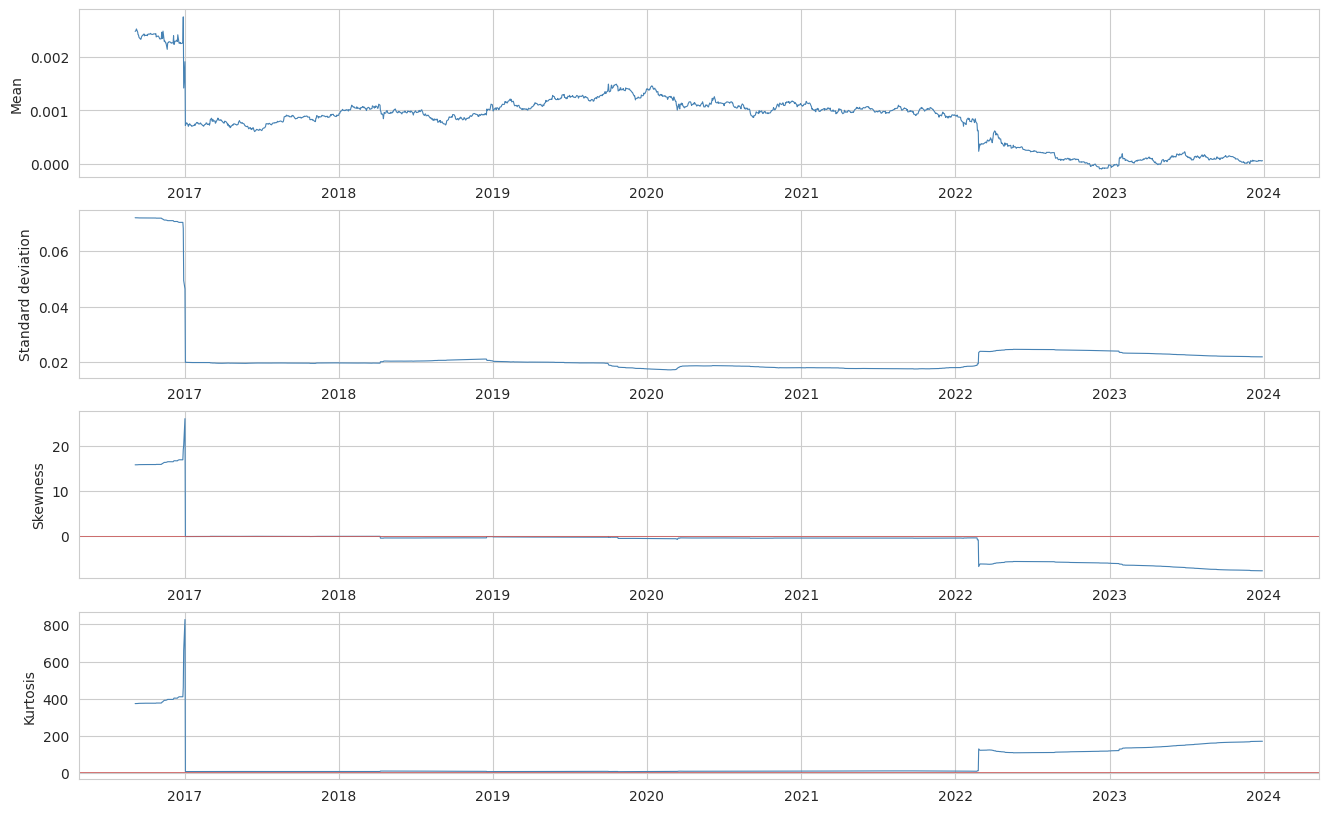

In [27]:
stock.get_moving_dynamic(window_size=1250)

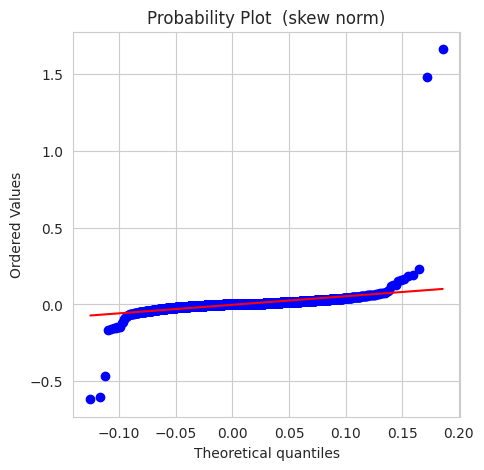

In [30]:
stock.qq_plot(dist='skew norm')

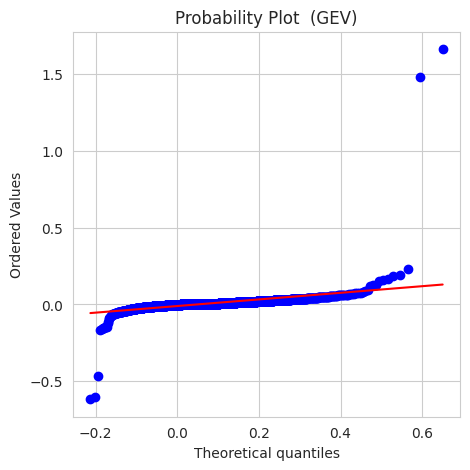

In [33]:
stock.qq_plot(dist='GEV')